In [1]:
from bp import build_image_factor_graph, Loopy_BP, URW_BP

import numpy as np
import matplotlib.pyplot as plt


from PIL import Image, ImageOps


import os

In [2]:
IMAGES = 'sideviews-cows2'

PATH_images = os.path.join('TUDarmstadt', 'PNGImages', IMAGES)
PATH_mask = os.path.join('TUDarmstadt', 'GTMasks', IMAGES)

# reduce the size of the image (otherwise sooooo long to build the factor graph -> implement without networkx ? in C/C++ ?)
REDUCTION_FACTOR = 3
NUM_PIXELS_INTENSITY = 64

images_names = os.listdir(PATH_images)


# get the images and the masks, using only 64 possible values for pixel intensities
images_grey = []
images_grey_back_rd = [] # images with random values for the background... 

images_mask = []

for img in images_names:
    img_path  = os.path.join(PATH_images, img)
    mask_path = os.path.join(PATH_mask, img)

    im_frame = Image.open(img_path).convert('L') # convert to grey scale
    im_mask = Image.open(mask_path)
    size = im_frame.size

    if REDUCTION_FACTOR > 1 :
        #
        im_frame = ImageOps.scale(im_frame, 1/REDUCTION_FACTOR)
        im_mask = ImageOps.scale(im_mask, 1/REDUCTION_FACTOR)

    img_array = np.array(im_frame)
    mask_array = np.array(im_mask)

    # reduce the number of pixel intensities
    img_array = (img_array * ((NUM_PIXELS_INTENSITY - 1) / 255)).astype(np.uint8)

    images_grey.append(img_array)

    img_array_back_rd = img_array.copy()
    img_array_back_rd[~mask_array] = np.random.randint(0, NUM_PIXELS_INTENSITY, size=img_array_back_rd[~mask_array].shape)
    images_grey_back_rd.append(img_array_back_rd)

    images_mask.append(np.array(im_mask))


In [3]:
IMG_NUM = -1

In [4]:
img = images_grey[IMG_NUM]
mask = images_mask[IMG_NUM]
img_shape = img.shape

(array([10., 17., 19., 52.,  0., 59., 64., 50., 51.,  0., 53., 54., 55.,
         0., 45., 73., 60., 42.,  0., 28., 34., 27.,  0., 16., 15., 10.,
        17.,  0., 14., 12., 10.,  0., 19., 13., 16., 15.,  0., 12., 11.,
         7., 13.,  0., 12., 11.,  8.,  0.,  9.,  9.,  9.,  7.,  0.,  4.,
        11.,  9.,  0.,  6., 17.,  5., 13.,  0.,  3.,  0.,  0.,  1.]),
 array([ 7.     ,  7.78125,  8.5625 ,  9.34375, 10.125  , 10.90625,
        11.6875 , 12.46875, 13.25   , 14.03125, 14.8125 , 15.59375,
        16.375  , 17.15625, 17.9375 , 18.71875, 19.5    , 20.28125,
        21.0625 , 21.84375, 22.625  , 23.40625, 24.1875 , 24.96875,
        25.75   , 26.53125, 27.3125 , 28.09375, 28.875  , 29.65625,
        30.4375 , 31.21875, 32.     , 32.78125, 33.5625 , 34.34375,
        35.125  , 35.90625, 36.6875 , 37.46875, 38.25   , 39.03125,
        39.8125 , 40.59375, 41.375  , 42.15625, 42.9375 , 43.71875,
        44.5    , 45.28125, 46.0625 , 46.84375, 47.625  , 48.40625,
        49.1875 , 49.96875

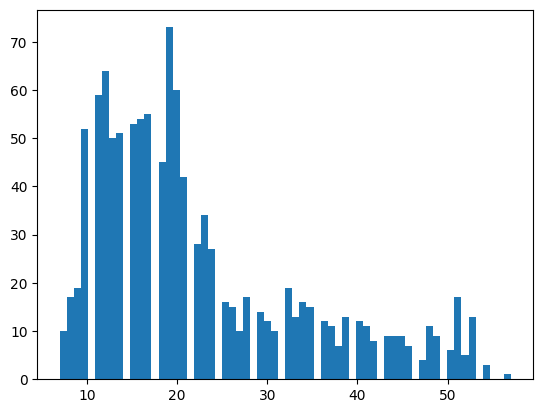

In [5]:
# histogram of the pixel intensities of the "segmented part" (cow, cars... NOT the all image)
plt.hist(img[mask], bins=NUM_PIXELS_INTENSITY)

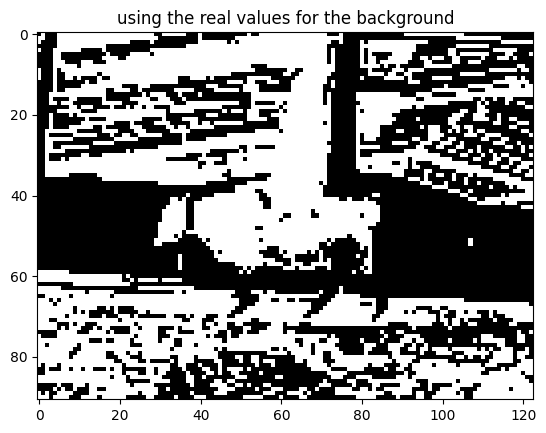

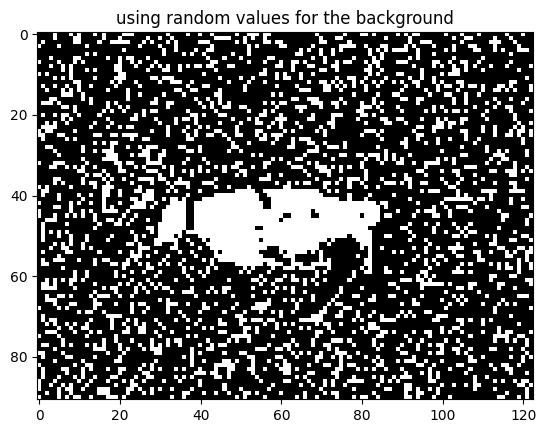

In [6]:
# just to see what it looks like just using the pixel intensities

im = images_grey[IMG_NUM]
im_back_rd = images_grey_back_rd[IMG_NUM]

# low, high = np.quantile(im[images_mask[IMG_NUM]], [0.1, 0.6]).astype(int)
low, high = 9, 23

def trans(im) :
    new_im = np.zeros(im.shape)
    for i, j in np.ndindex(im.shape):
        if im[i, j] < low or im[i, j] > high:
            new_im[i, j] = 0
        else:
            new_im[i, j] = 1
    return new_im


plt.imshow(trans(im), cmap='gray')
plt.title('using the real values for the background')
plt.show()

plt.imshow(trans(im_back_rd), cmap='gray')
plt.title('using random values for the background')
plt.show()

In [7]:
### build the factor distribs of the graph

# distrib for factor from pixel intensity
distrib_int_obs = np.zeros((64, 2)) + .1
distrib_int_obs[low:high, 1] = 1
distrib_int_obs[:low, 0] = 1
distrib_int_obs[high:, 0] = 1


# distrib for factor from class interaction
distrib_clc_neigh = np.array([[1, .1], [.1, 1]])


In [8]:
# build the factor graphs for the images (!! can be really long on high resolution images !!)
graph           = build_image_factor_graph(images_grey[IMG_NUM], distrib_int_obs, distrib_clc_neigh)
graph_back_rd   = build_image_factor_graph(images_grey_back_rd[IMG_NUM], distrib_int_obs, distrib_clc_neigh)

# Belief propagation (Loopy and URW)

In [9]:
N = 20

In [10]:
# beliefs propagation using URW_BP

model_URW = URW_BP(graph)
model_URW_back_rd = URW_BP(graph_back_rd)

beliefs_evol_URW = [] # to keep track of the beliefs evolution on one of the classes
beliefs_evol_URW_back_rd = []

for i in range(N) :
    print(i, end='\r')

    model_URW.loop()
    beliefs = np.array([model_URW.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_URW.append(beliefs[:, 1].reshape(img_shape))

    model_URW_back_rd.loop()
    beliefs = np.array([model_URW_back_rd.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_URW_back_rd.append(beliefs[:, 1].reshape(img_shape))

In [ ]:
# beliefs propagation using loopy BP

model_loopy = Loopy_BP(graph)
model_loopy_back_rd = Loopy_BP(graph_back_rd)

beliefs_evol_loopy = [] # to keep track of the beliefs evolution on one of the classes
beliefs_evol_loopy_back_rd = []

for i in range(N) :
    print(i, end='\r')

    model_loopy.loop()
    beliefs = np.array([model_loopy.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_loopy.append(beliefs[:, 1].reshape(img_shape))

    model_loopy_back_rd.loop()
    beliefs = np.array([model_loopy_back_rd.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(img_shape)])
    beliefs_evol_loopy_back_rd.append(beliefs[:, 1].reshape(img_shape))

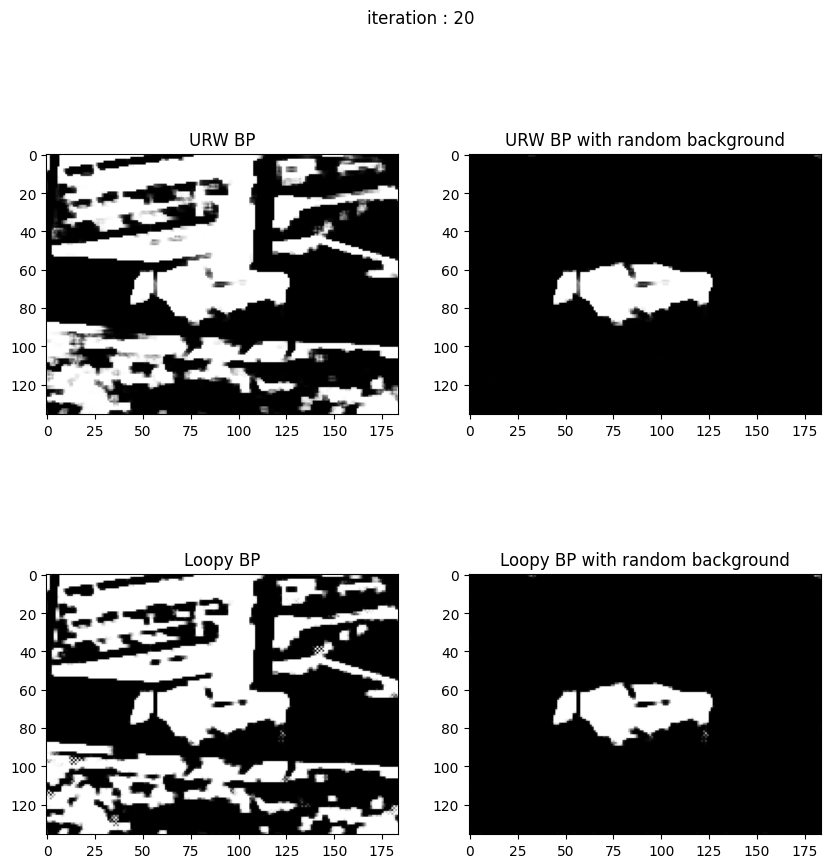

In [ ]:
# build a little anim to visualise all that

from matplotlib.animation import FuncAnimation


# Create a figure and axis
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(10, 10))
suptitle = fig.suptitle('iteration : 1')


# Initialize the imshow plot with the first frame of data
im00 = ax00.imshow(beliefs_evol_URW[0], cmap='grey', vmin=0, vmax=1)
ax00.set_title('URW BP')

im01 = ax01.imshow(beliefs_evol_URW_back_rd[0], cmap='grey', vmin=0, vmax=1)
ax01.set_title('URW BP with random background')

im10 = ax10.imshow(beliefs_evol_loopy[0], cmap='grey', vmin=0, vmax=1)
ax10.set_title('Loopy BP')

im11 = ax11.imshow(beliefs_evol_loopy_back_rd[0], cmap='grey', vmin=0, vmax=1)
ax11.set_title('Loopy BP with random background')

# Function to update the plot for each frame of the animation
def update(frame):
    suptitle.set_text('iteration : {}'.format(frame+1))
    im00.set_array(beliefs_evol_URW[frame])  
    im01.set_array(beliefs_evol_URW_back_rd[frame])  
    im10.set_array(beliefs_evol_loopy[frame])  
    im11.set_array(beliefs_evol_loopy_back_rd[frame])  
    return suptitle, im00, im01, im10, im11

# Create the animation
ani = FuncAnimation(fig, update, frames=range(N))  


# Save the animation as a gif
save_to = os.path.join('res', '{}_red{}_Npxl{}__{}_{}.gif'.format(images_names[IMG_NUM], REDUCTION_FACTOR, NUM_PIXELS_INTENSITY, low, high))
ani.save(save_to, writer='pillow', fps=2)  # Adjust fps as needed
plt.show()
